In [1]:
import or_gym
from or_gym.benchmarks.newsvendor.nv_benchmark import *
from or_gym.benchmarks.newsvendor.onv_benchmark import *
import matplotlib.pyplot as plt
import pyomo.environ as pe

In [2]:
#create environments for 5 cases
env1_dfo=or_gym.make("NewsVendor-v1")#,env_config={'periods':20})
env1_mip=or_gym.make("NewsVendor-v1")#,env_config={'periods':20})
env1_mip_pi=or_gym.make("NewsVendor-v1")#,env_config={'periods':20})
env1_dfo_online=or_gym.make("NewsVendor-v1")#,env_config={'periods':20})
env1_mip_online=or_gym.make("NewsVendor-v1")#,env_config={'periods':20})

C:\ProgramData\Miniconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#run optimizations for backlog scenario
env1_dfo_results = optimize_nv_dfo(env1_dfo)

   direc: array([[   1.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ],
       [-242.43186687,  110.48948914,  164.23304955]])
    fopt: 0.5353396383764859
     fun: -0.535444877561173
 message: 'Optimization terminated successfully.'
    nfev: 515
     nit: 8
  status: 0
 success: True
       x: array([ 81.99986982, 115.00000333, 216.14822517])
    xopt: array([ 82., 115., 217.])
    zopt: array([ 82., 197., 414.])


In [4]:
env1_mip_model, env1_mip_results = optimize_nv_mip(env1_mip,warmstart=True,
                                                   warmstart_kwargs={'mapping_env': env1_dfo,
                                                                     'mapping_z':env1_dfo_results.zopt})

Academic license - for non-commercial use only
Read LP format model from file C:\Users\HD\AppData\Local\Temp\tmpax2u_k0e.pyomo.lp
Reading time = 0.03 seconds
x3343: 4147 rows, 2980 columns, 15865 nonzeros
Read MIP start from file C:\Users\HD\AppData\Local\Temp\tmpj5a42wxc.gurobi.mst
Optimize a model with 4147 rows, 2980 columns and 15865 nonzeros
Variable types: 1897 continuous, 1083 integer (1080 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+04]
  Objective range  [4e-05, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

Loaded MIP start with objective 0.53534

Presolve removed 1235 rows and 765 columns
Presolve time: 0.03s
Presolved: 2912 rows, 2215 columns, 10827 nonzeros
Variable types: 1233 continuous, 982 integer (977 binary)

Root relaxation: objective 8.155037e-01, 2277 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

In [53]:
env1_mip_pi_model, env1_mip_pi_results = optimize_nv_pi_mip(env1_mip_pi,warmstart=True,
                                                   warmstart_kwargs={'mapping_env': env1_dfo,
                                                                     'mapping_z':env1_dfo_results.zopt,
                                                                     'perfect_information':True})

Academic license - for non-commercial use only
Read LP format model from file C:\Users\HD\AppData\Local\Temp\tmp6p4q50dt.pyomo.lp
Reading time = 0.01 seconds
x1627: 1891 rows, 1621 columns, 6428 nonzeros
Read MIP start from file C:\Users\HD\AppData\Local\Temp\tmp1j8q7hjp.gurobi.mst
Optimize a model with 1891 rows, 1621 columns and 6428 nonzeros
Coefficient statistics:
  Matrix range     [2e-03, 2e+00]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1099 rows and 819 columns
Presolve time: 0.00s
Presolved: 792 rows, 802 columns, 3445 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3583140e+02   2.320974e+04   0.000000e+00      0s
     555    8.6186344e+00   0.000000e+00   0.000000e+00      0s

Solved in 555 iterations and 0.02 seconds
Optimal objective  8.618634418e+00


In [6]:
_,_,env1_dfo_online_basestock = online_optimize_nv_dfo(env1_dfo_online)

*******************************************
Period: 1 

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.07762142e-07, -1.06805013e-08, -4.80546733e-07]])
    fopt: 3.553412695683392
     fun: -3.5638111375891555
 message: 'Optimization terminated successfully.'
    nfev: 204
     nit: 2
  status: 0
 success: True
       x: array([ 21.17922937,  -1.        , -87.99580146])
    xopt: array([21.,  0.,  0.])
    zopt: array([21., 21., 21.])
*******************************************
Period: 2 

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.15786059,  0.34348095,  0.00694981]])
    fopt: 2.9360072398084025
     fun: -2.9627177819089487
 message: 'Optimization terminated successfully.'
    nfev: 302
     nit: 5
  status: 0
 success: True
       x: array([ 42.01096016, -85.99657947,  -0.99995758])
    xopt: array([42.,  0.,  0.])


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2376: RuntimeWarning: overflow encountered in double_scalars
  if (w - xc) * (xb - w) > 0.0:
C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2396: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(xc - w) > 0.0:
C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2392: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2371: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2364: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:2365: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - x

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1481
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 9 

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1480
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 10 

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.54955013e-07,  1.28799978e-09, -2.57599956e-09]])
    fopt: 0.9280048516583297
     fun: -0.9316725349699244
 message: 'Optimization terminated successfully.'
 

In [7]:
_,_,env1_mip_online_basestock = online_optimize_nv_mip(env1_mip_online,warmstart=True)

*******************************************
Period: 1 

Academic license - for non-commercial use only
Read LP format model from file C:\Users\HD\AppData\Local\Temp\tmpaa363lsp.pyomo.lp
Reading time = 0.01 seconds
x50: 53 rows, 43 columns, 146 nonzeros
Optimize a model with 53 rows, 43 columns and 146 nonzeros
Variable types: 28 continuous, 15 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  Objective range  [8e-02, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 53 rows and 43 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 3.55341 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.553412695683e+00, best bound 3.553412695683e+00, gap 0.0000%
*******************************************
Period: 2 

Academic lice

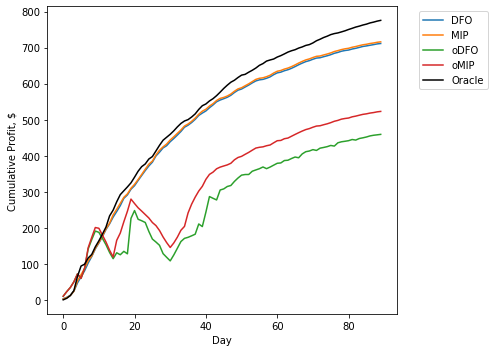

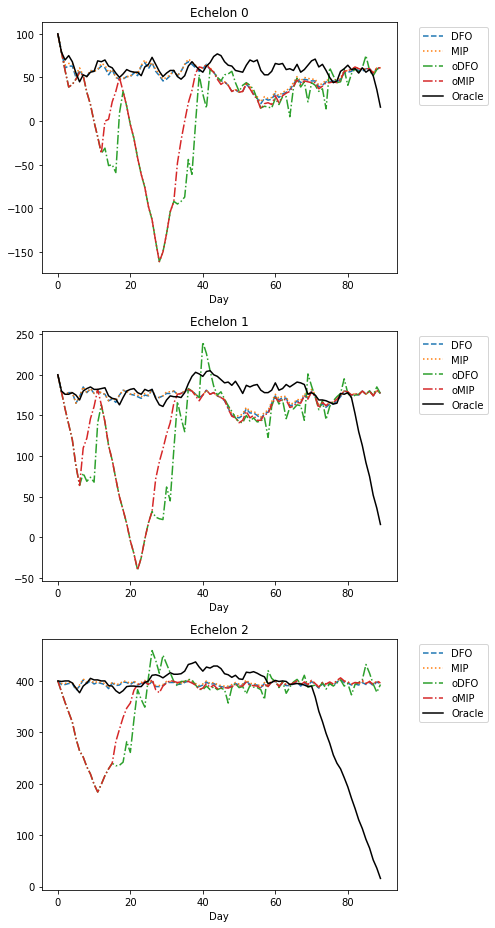

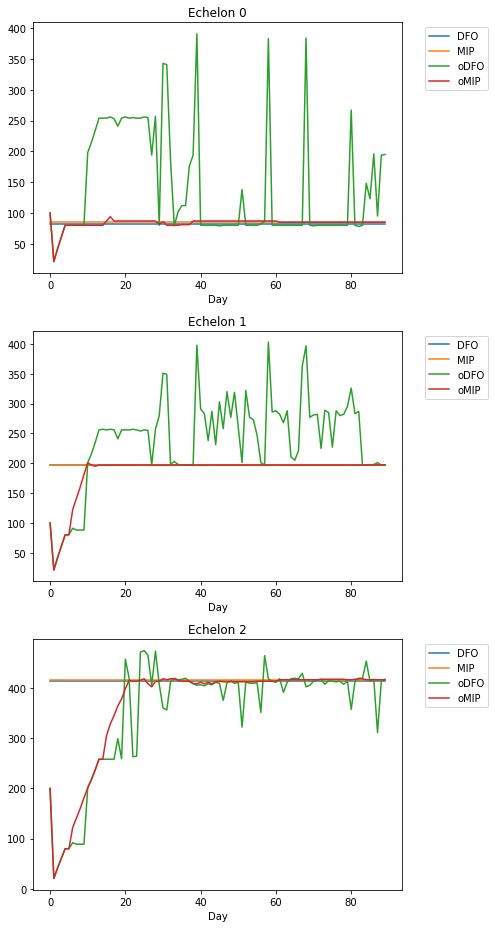

In [54]:
#plot results for backlog scenario

#profit
fig = plt.figure(figsize=[7,5])
plt.plot(np.cumsum(env1_dfo.P),label='DFO')
plt.plot(np.cumsum(env1_mip.P),label='MIP')
plt.plot(np.cumsum(env1_dfo_online.P),label='oDFO')
plt.plot(np.cumsum(env1_mip_online.P),label='oMIP')
plt.plot(np.cumsum(env1_mip_pi.P),'k',label='Oracle')
plt.xlabel('Day')
plt.ylabel('Cumulative Profit, $')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_Backlog.png')
plt.show()

#base stock levels
N = env1_dfo.num_periods
M = env1_dfo.num_stages
env1_dfo_online_basestock = np.array(env1_dfo_online_basestock)
env1_mip_online_basestock = np.array(env1_mip_online_basestock)

def inventory_position(I,T,B,stage):
    return np.sum(I[:-1,:stage+1] + T[:-1,:stage+1] - np.row_stack((np.zeros(stage+1),B[:-1,:i+1])),axis=1)

fig, axs = plt.subplots(3,1,figsize=[7,13])
axs = axs.ravel()
for i in range(M-1):
    axs[i].set_prop_cycle(None)
    axs[i].set_title('Echelon %i' %i)
    axs[i].set_xlabel('Day')

    #plot base stock levels
#     axs[i].plot(env1_dfo_results.zopt[i]*np.ones(N),label='DFO BSL')
#     axs[i].plot(pe.value(env1_mip_model.z[i])*np.ones(N),label='MIP BSL')
#     axs[i].plot(np.append(env1_dfo_online.init_inv[i],env1_dfo_online_basestock[:,i]),label='oDFO BSL')
#     axs[i].plot(np.append(env1_mip_online.init_inv[i],env1_mip_online_basestock[:,i]),label='oMIP BSL')
    
    axs[i].set_prop_cycle(None)
    #plot actual inventory positions
    axs[i].plot(inventory_position(I = env1_dfo.I, T = env1_dfo.T, B = env1_dfo.B, stage = i),'--',label='DFO')
    axs[i].plot(inventory_position(I = env1_mip.I, T = env1_mip.T, B = env1_mip.B, stage = i),':',label='MIP')
    axs[i].plot(inventory_position(I = env1_dfo_online.I, T = env1_dfo_online.T, B = env1_dfo_online.B, stage = i),'-.',label='oDFO')
    axs[i].plot(inventory_position(I = env1_mip_online.I, T = env1_mip_online.T, B = env1_mip_online.B, stage = i),'-.',label='oMIP')
    axs[i].plot(inventory_position(I = env1_mip_pi.I, T = env1_mip_pi.T, B = env1_mip_pi.B, stage = i),'k',label='Oracle')
    axs[i].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_Backlog_inventory.png')
plt.show()

fig, axs = plt.subplots(3,1,figsize=[7,13])
axs = axs.ravel()
for i in range(M-1):
    axs[i].set_prop_cycle(None)
    axs[i].set_title('Echelon %i' %i)
    axs[i].set_xlabel('Day')

    #plot base stock levels
    axs[i].plot(env1_dfo_results.zopt[i]*np.ones(N),label='DFO')
    axs[i].plot(pe.value(env1_mip_model.z[i])*np.ones(N),label='MIP')
    axs[i].plot(np.append(env1_dfo_online.init_inv[i],env1_dfo_online_basestock[:,i]),label='oDFO')
    axs[i].plot(np.append(env1_mip_online.init_inv[i],env1_mip_online_basestock[:,i]),label='oMIP')
    
#     axs[i].set_prop_cycle(None)
#     #plot actual inventory positions
#     axs[i].plot(inventory_position(I = env1_dfo.I, T = env1_dfo.T, B = env1_dfo.B, stage = i),'--',label='DFO TIL')
#     axs[i].plot(inventory_position(I = env1_mip.I, T = env1_mip.T, B = env1_mip.B, stage = i),':',label='MIP TIL')
#     axs[i].plot(inventory_position(I = env1_dfo_online.I, T = env1_dfo_online.T, B = env1_dfo_online.B, stage = i),'-.',label='oDFO TIL')
#     axs[i].plot(inventory_position(I = env1_mip_online.I, T = env1_mip_online.T, B = env1_mip_online.B, stage = i),'-.',label='oMIP TIL')
#     axs[i].plot(inventory_position(I = env1_mip_pi.I, T = env1_mip_pi.T, B = env1_mip_pi.B, stage = i),'k',label='Oracle TIL')
    axs[i].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_Backlog_zopt.png')
plt.show()
                
# #on hand inventory levels
# env1_dfo_online_basestock = np.array(env1_dfo_online_basestock)
# env1_mip_online_basestock = np.array(env1_mip_online_basestock)
# fig, axs = plt.subplots(3,1,figsize=[5,10])
# axs = axs.ravel()
# for i in range(M-1):
#     axs[i].set_title('Stage %i' %i)
#     axs[i].set_xlabel('Day')
#     axs[i].plot(env1_dfo.I[:,i],label='DFO')
#     axs[i].plot(np.reshape(list(env1_mip_model.I.get_values().values()),(N+1,env1_dfo.num_stages-1))[:,i],label='MIP')
#     axs[i].plot(env1_dfo_online.I[:,i],label='oDFO')
#     axs[i].plot(env1_mip_online.I[:,i],label='oMIP')
#     axs[i].legend()
# plt.tight_layout()
# plt.show()